In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [2]:
tf.random.set_seed(1) # Set global random seed for reproducibility
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [3]:
########## 加载具体的光追场景################
scene = load_scene('/root/autodl-tmp/sionna/Single Box/Single Box.xml') # Try also sionna.rt.scene.etoile
'''
if colab_compat:
    scene.render(camera="scene-cam-0", num_samples=512);
    raise ExitCell
'''
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [4]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

################创建发射机#########################
tx = Transmitter(name="tx",
                 position=[8.5,19,15])
################ 将发射机加入到场景中##############
scene.add(tx)
#################创建接收机########################
rx = Receiver(name="rx",
              position=[8.5,19,15],
              orientation=[0,0,0])
################ 将接收机加入到场景中##############
scene.add(rx)
tx.look_at(rx) ####### 使发射机指向接收机################

In [5]:
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [6]:
# Select an example object from the scene
so = scene.get("Altes_Rathaus-itu_marble")

# Print name of assigned radio material for different frequenies
for f in [3.5e9, 2.14e9]: # Print for differrent frequencies
    scene.frequency = f
    '''
    print(f"\nRadioMaterial: {so.radio_material.name} @ {scene.frequency/1e9:.2f}GHz")
    print("Conductivity:", so.radio_material.conductivity.numpy())
    print("Relative permittivity:", so.radio_material.relative_permittivity.numpy())
    print("Complex relative permittivity:", so.radio_material.complex_relative_permittivity.numpy())
    print("Relative permeability:", so.radio_material.relative_permeability.numpy())
    print("Scattering coefficient:", so.radio_material.scattering_coefficient.numpy())
    print("XPD coefficient:", so.radio_material.xpd_coefficient.numpy())
    print("Trainable relative permittivity:", so.radio_material.trainable_relative_permittivity)
    print("Trainable conductivity:", so.radio_material.trainable_conductivity)
    print("Trainable scattering coefficient:", so.radio_material.trainable_scattering_coefficient)
    print("Trainable XPD coefficient:", so.radio_material.trainable_xpd_coefficient)
    '''

In [7]:
################计算光线传播路径################
paths = scene.compute_paths(max_depth=6,
                            num_samples=5e4,
                            reflection = True,
                            scattering = True)  # Number of rays shot into directions defined
                                              # by a Fibonacci spheree , too few rays can
                                              # lead to missing paths
'''
# Visualize paths in the 3D preview
my_cam2 = Camera("my_cam2", position=[-250,250,150], look_at=[-15,30,28])
scene.add(my_cam2)
if colab_compat:
    scene.render("my_cam2", paths=paths, show_devices=True, show_paths=True, resolution=resolution);
    raise ExitCell
'''
scene.preview(paths, show_devices=True, show_paths=True) # Use the mouse to focus on the visualized paths
############渲染生成的场景图到文件中###################3
#render_to_file = True # Set to True to render image to file
## Render scene to file from preview viewpoint
#if render_to_file:
    #scene.render_to_file(camera="my_cam", # Also try camera="preview"
                         #filename="/root/autodl-tmp/sionna/scene_withpath.png",
                         #resolution=[650,500])

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [8]:
# Show the coordinates of the starting points of all rays.
# These coincide with the location of the transmitters.
print("Source coordinates: ", paths.sources.numpy())
print("Transmitter coordinates: ", list(scene.transmitters.values())[0].position.numpy())

# Show the coordinates of the endpoints of all rays.
# These coincide with the location of the receivers.
print("Target coordinates: ",paths.targets.numpy())
print("Receiver coordinates: ",list(scene.receivers.values())[0].position.numpy())

# Show the types of all paths:
# 0 - LoS, 1 - Reflected, 2 - Diffracted, 3 - Scattered
# Note that Diffraction and scattering are turned off by default.
print("Path types: ", paths.types.numpy())

Source coordinates:  [[ 8.5 19.  15. ]]
Transmitter coordinates:  [ 8.5 19.  15. ]
Target coordinates:  [[ 8.5 19.  15. ]]
Receiver coordinates:  [ 8.5 19.  15. ]
Path types:  [[1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [9]:
# We can now access for every path the channel coefficient, the propagation delay,
# as well as the angles of departure and arrival, respectively (zenith and azimuth).

# Let us inspect a specific path in detail
path_idx = 0 # Try out other values in the range [0, 13]

# For a detailed overview of the dimensions of all properties, have a look at the API documentation
print(f"\n--- Detailed results for path {path_idx} ---")
print(f"Channel coefficient: {paths.a[0,0,0,0,0,path_idx, 0].numpy()}")
print(f"Propagation delay: {paths.tau[0,0,0,path_idx].numpy()*1e6:.5f} us")
print(f"Zenith angle of departure: {paths.theta_t[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of departure: {paths.phi_t[0,0,0,path_idx]:.4f} rad")
print(f"Zenith angle of arrival: {paths.theta_r[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of arrival: {paths.phi_r[0,0,0,path_idx]:.4f} rad")


--- Detailed results for path 0 ---
Channel coefficient: (1.970798958056408e-12-1.4099280824884236e-13j)
Propagation delay: 0.00000 us
Zenith angle of departure: 3.1416 rad
Azimuth angle of departure: 0.0000 rad
Zenith angle of arrival: 3.1416 rad
Azimuth angle of arrival: -3.1416 rad


In [10]:
# Default parameters in the PUSCHConfig
subcarrier_spacing = 15e3
fft_size = 48
# Print shape of channel coefficients before the application of Doppler shifts
# The last dimension corresponds to the number of time steps which defaults to one
# as there is no mobility
print("Shape of `a` before applying Doppler shifts: ", paths.a.shape)
# Apply Doppler shifts
paths.apply_doppler(sampling_frequency=subcarrier_spacing, # Set to 15e3 Hz
                    num_time_steps=14, # Number of OFDM symbols
                    tx_velocities=[3.,0,0], # We can set additional tx speeds
                    rx_velocities=[0,7.,0]) # Or rx speeds
#print("Shape of `a` after applying Doppler shifts: ", paths.a.shape)
a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

######目前先不考虑多普勒频移#########

Shape of `a` before applying Doppler shifts:  (1, 1, 2, 1, 1, 20, 1)
Shape of tau:  (1, 1, 1, 20)


[  0.           0.           0.89657706   3.55214524   6.10275221
  15.31891823  16.76856804  25.48185349  32.88130569  35.43044662
  42.585186    43.72491074  49.44854736  50.47415924  73.97621155
  86.37666321  90.01739502 108.42568207 172.80712891 238.45982361
 332.60632324 365.86695557]
[           nan 1.97583594e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00            nan]


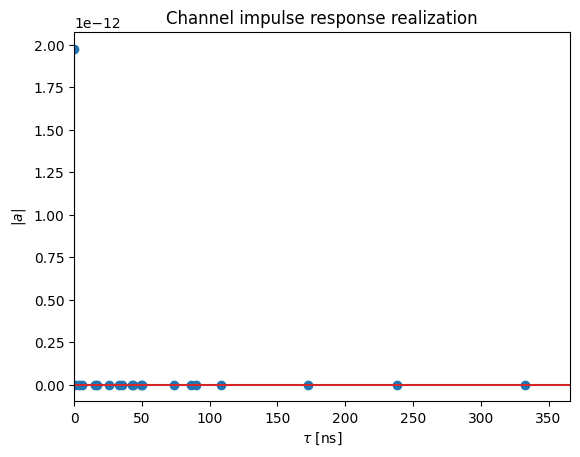

In [11]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
print(t)
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])
print(a_abs)
# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
#plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [12]:
#### 请注意，第一个到达路径的延迟被归一化为零。可以使用 Paths 的 call 属性更改此行为。
#######对于链路级仿真，建议使用归一化延迟，除非明确要求完美同步
paths.normalize_delays = False

# Get only the LoS path
_, tau = paths.cir(los=True, reflection=True,scattering = True)
print("Delay of first path without normalization: ", np.squeeze(tau))

paths.normalize_delays = True
_, tau = paths.cir(los=True, reflection=False,scattering = True)
print("Delay of first path with normalization: ", np.squeeze(tau))

Delay of first path without normalization:  [1.00069229e-07 1.00965806e-07 1.03621375e-07 1.06171981e-07
 1.15388147e-07 1.16837796e-07 1.25551082e-07 1.32950532e-07
 1.35499675e-07 1.42654415e-07 1.43794139e-07 1.49517774e-07
 1.50543386e-07 1.74045439e-07 1.86445888e-07 1.90086624e-07
 2.08494910e-07 2.72876349e-07 3.38529048e-07 4.32675535e-07]
Delay of first path with normalization:  [8.9657703e-10 3.5521452e-09 6.1027521e-09 1.5318918e-08 1.6768567e-08
 2.5481853e-08 3.2881303e-08 3.5430446e-08 4.2585185e-08 4.3724910e-08
 4.9448545e-08 5.0474156e-08 7.3976210e-08 8.6376659e-08 9.0017394e-08
 1.0842568e-07 1.7280712e-07 2.3845982e-07 3.3260631e-07]


In [13]:
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)
print(frequencies.shape)
# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True) # Non-normalized includes path-loss

# Verify that the channel power is normalized
h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

print("Shape of h_freq: ", h_freq.shape)
print("Average power h_freq: ", h_avg_power) # Channel is normalized

(48,)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input for dynamic binary or n-ary op lowering was of a rank greater than 5 [Op:Mul] name: 

In [ ]:
# Placeholder for tx signal of shape
# [batch size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
x = tf.zeros([h_freq.shape.as_list()[i] for i in [0,3,4,5,6]], tf.complex64)

no = 0.1 # noise variance

# Init channel layer
channel = ApplyOFDMChannel(add_awgn=True)

# Apply channel
y = channel([x, h_freq, no])

# [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size]
print(y.shape)